I followed the tutoral by Sovid Ranja Rath to train a Vanilla GAN to generate MNIST Digit images

https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/

## Training the Discriminator

- First, we get the real data and the real labels (real labels are all 1s). The length of the real label should be equal to the batch size.

- Then we do a forward pass by feeding the real data to the discriminator neural network. This gives us the real outputs from the real data.

- Calculate the discriminator loss for the real outputs and labels and backpropagate it.

- Get the fake data using the noise vector and doing a forward pass through the generator. Get fake labels as well.

- Using the fake data, do a forward pass through the discriminator. Calculate the loss using the fake data outputs and the fake labels. Backpropagate the fake data loss. Then calculate the total discriminator loss by adding real data loss and fake data loss.

- Update the discriminator optimizer parameters.

## Training the Generator
- For the generator training, first, get the fake data by doing a forward pass through the generator. Get the real labels (all 1s).

- Then do a forward pass through the discriminator using the fake data and the labels.

- Calculate the loss and backpropagate them.

- But this time, update the generator optimizer parameters.


Import modules and libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

Define the learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size or noise vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Prepare dataset

line 1 will convert the image to tensors and normalizes them.

line 6 will convert the images to the PIL image format.

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [4]:
train_data = datasets.MNIST(
    root='./input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## Generator Neural Network

4 linear layers with LeakyReLu activations in-between

forward( ) returns the outputs after reshaping them into batch_size * 1 * 28 * 28

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

## Discriminator Neural Network

forward( ) makes a forward pass of the data through the discriminator network. It returns the binary classification of whether an image is fake or real (0 or 1)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


## Initialize the Neural Networks and Define the Optimizers


In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [9]:
# loss function, Binary Cross Entropy Loss Function
criterion = nn.BCELoss()

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

## Utility Functions

Real and fake labels for the real image and the fake image data from the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

## Function to Train the Discriminator
- At line 3, we get the batch size of the data. Then we use the batch size to create the fake and real labels at lines 4 and 5.
- Before doing any training, we first set the gradients to zero at line 7.
- At line 9, we get the output_real by doing a forward pass of the real data (data_real) through the discriminator. Line 10 calculates the loss for the real outputs and the real labels.
- Similarly, at line 12, we get fake outputs using fake data. And line 13, calculates the loss for the fake outputs and the fake labels.
- Lines 16 to 18 backpropagate the gradients for the fake and the real loss and update the parameters as well.
- Finally, at line 20, we return the total loss for the discriminator network.

In [14]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)  #get the batck size
    
    #create labels
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    
    optimizer.zero_grad()
    
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

## Function to Train the Generator
- First, we get the batch size at line 3 and then create the real labels at line 4. Remember that the fake data is actually real for the generator. Therefore, we are using real labels (ones) for training the generator network.
- At line 6, we set the gradients to zero.
- The next step is a bit important. At line 8, we pass the fake data through the discriminator and get the outputs. Then at line 9, we calculate the loss using the outputs and the real labels.
- Remember that the generator only generates fake data. And it improves after each iteration by taking in the feedback from the discriminator.
- At line 11, we backpropagate the gradients.
- Now, at line 12, we update the generator parameters and not the discriminator parameters. Because in this step, we want the generator to learn, not the discriminator. The optimizer parameter in the function definition is the optim_g that we will pass as the argument while calling the function.


In [15]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

## Training the GAN

In [16]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [17]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

## The Training Loop
- At lines 2 and 3, we define loss_g and loss_d to keep track of the batch-wise loss values for the discriminator and the generator.
- Starting from line 4, we iterate through the batches. We only need the image data. Therefore, we get the images only at line 5 and load them to the computation device at line 6. Line 7 calculates the batch size.
- Starting from line 9 till 13, we run the discriminator for k number of steps. And remember that for our purpose we have defined k = 1. This is the least expensive option as this will train one step of the discriminator and one step of the generator. You can play around with the value of k. But remember that the computation time will also increase with an increase in the value of k.
- Also, note that we are passing the discriminator optimizer while calling train_discriminator() at line 13.
- At line 14, we again create a new noise vector. This we pass as an argument along with the generator optimizer while calling train_generator().
- At line 19, we create the final fake images for the current epoch and load them onto the CPU so that we can save them to the disk. Line 21 makes a grid of those images.
- Line 23 saves the generated images to disk. And line 24 appends those images to the images list.
- Finally, from line 25 to 31, we calculate the epoch-wise loss of the generator and the discriminator and print those loss values.


In [27]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./output/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.detach())
    losses_d.append(epoch_loss_d.detach())
    
    print(f"Epoch {epoch + 1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:07, 15.24it/s]                                                        


Epoch 1 of 200
Generator loss: 1.31588411, Discriminator loss: 1.07365131


118it [00:07, 15.43it/s]                                                        


Epoch 2 of 200
Generator loss: 1.26580298, Discriminator loss: 1.10635900


118it [00:07, 15.31it/s]                                                        


Epoch 3 of 200
Generator loss: 1.26872075, Discriminator loss: 1.08452678


118it [00:07, 14.99it/s]                                                        


Epoch 4 of 200
Generator loss: 1.26313806, Discriminator loss: 1.09225130


118it [00:07, 15.23it/s]                                                        


Epoch 5 of 200
Generator loss: 1.25280702, Discriminator loss: 1.08617532


118it [00:07, 15.29it/s]                                                        


Epoch 6 of 200
Generator loss: 1.31067789, Discriminator loss: 1.07320440


118it [00:07, 15.41it/s]                                                        


Epoch 7 of 200
Generator loss: 1.23154426, Discriminator loss: 1.10416698


118it [00:07, 14.90it/s]                                                        


Epoch 8 of 200
Generator loss: 1.28486323, Discriminator loss: 1.07916927


118it [00:08, 14.68it/s]                                                        


Epoch 9 of 200
Generator loss: 1.24432373, Discriminator loss: 1.10375047


118it [00:07, 15.20it/s]                                                        


Epoch 10 of 200
Generator loss: 1.30355370, Discriminator loss: 1.08960116


118it [00:07, 15.19it/s]                                                        


Epoch 11 of 200
Generator loss: 1.25671959, Discriminator loss: 1.11372197


118it [00:07, 15.15it/s]                                                        


Epoch 12 of 200
Generator loss: 1.27409923, Discriminator loss: 1.09984052


118it [00:07, 15.04it/s]                                                        


Epoch 13 of 200
Generator loss: 1.29283512, Discriminator loss: 1.08221257


118it [00:07, 15.32it/s]                                                        


Epoch 14 of 200
Generator loss: 1.29557860, Discriminator loss: 1.07927036


118it [00:07, 15.36it/s]                                                        


Epoch 15 of 200
Generator loss: 1.28305244, Discriminator loss: 1.07935131


118it [00:07, 15.13it/s]                                                        


Epoch 16 of 200
Generator loss: 1.26286304, Discriminator loss: 1.08941591


118it [00:07, 14.86it/s]                                                        


Epoch 17 of 200
Generator loss: 1.25351012, Discriminator loss: 1.10394931


118it [00:07, 15.19it/s]                                                        


Epoch 18 of 200
Generator loss: 1.23831725, Discriminator loss: 1.09317327


118it [00:07, 15.13it/s]                                                        


Epoch 19 of 200
Generator loss: 1.21511674, Discriminator loss: 1.10788405


118it [00:07, 14.96it/s]                                                        


Epoch 20 of 200
Generator loss: 1.19641483, Discriminator loss: 1.12115633


118it [00:07, 15.15it/s]                                                        


Epoch 21 of 200
Generator loss: 1.20153117, Discriminator loss: 1.13102806


118it [00:07, 15.22it/s]                                                        


Epoch 22 of 200
Generator loss: 1.17079532, Discriminator loss: 1.14443493


118it [00:07, 15.29it/s]                                                        


Epoch 23 of 200
Generator loss: 1.20061791, Discriminator loss: 1.11613488


118it [00:07, 15.31it/s]                                                        


Epoch 24 of 200
Generator loss: 1.20564997, Discriminator loss: 1.13076282


118it [00:07, 15.16it/s]                                                        


Epoch 25 of 200
Generator loss: 1.22100317, Discriminator loss: 1.11827767


118it [00:08, 14.65it/s]                                                        


Epoch 26 of 200
Generator loss: 1.19388056, Discriminator loss: 1.12239110


118it [00:07, 14.77it/s]                                                        


Epoch 27 of 200
Generator loss: 1.20904148, Discriminator loss: 1.12050438


118it [00:07, 15.06it/s]                                                        


Epoch 28 of 200
Generator loss: 1.17187107, Discriminator loss: 1.12874234


118it [00:07, 15.12it/s]                                                        


Epoch 29 of 200
Generator loss: 1.18469870, Discriminator loss: 1.13349247


118it [00:07, 14.91it/s]                                                        


Epoch 30 of 200
Generator loss: 1.23550963, Discriminator loss: 1.11128271


118it [00:07, 15.10it/s]                                                        


Epoch 31 of 200
Generator loss: 1.21256924, Discriminator loss: 1.13955140


118it [00:07, 14.88it/s]                                                        


Epoch 32 of 200
Generator loss: 1.23812902, Discriminator loss: 1.12996686


118it [00:07, 14.92it/s]                                                        


Epoch 33 of 200
Generator loss: 1.12794602, Discriminator loss: 1.15345764


118it [00:07, 15.19it/s]                                                        


Epoch 34 of 200
Generator loss: 1.19324481, Discriminator loss: 1.11565912


118it [00:07, 15.14it/s]                                                        


Epoch 35 of 200
Generator loss: 1.20016444, Discriminator loss: 1.13523948


118it [00:07, 15.53it/s]                                                        


Epoch 36 of 200
Generator loss: 1.18956912, Discriminator loss: 1.13061500


118it [00:07, 15.50it/s]                                                        


Epoch 37 of 200
Generator loss: 1.19080019, Discriminator loss: 1.12928414


118it [00:07, 15.44it/s]                                                        


Epoch 38 of 200
Generator loss: 1.17574370, Discriminator loss: 1.12450397


118it [00:07, 15.41it/s]                                                        


Epoch 39 of 200
Generator loss: 1.19032669, Discriminator loss: 1.13795376


118it [00:07, 15.47it/s]                                                        


Epoch 40 of 200
Generator loss: 1.15194714, Discriminator loss: 1.13620961


118it [00:07, 15.46it/s]                                                        


Epoch 41 of 200
Generator loss: 1.19285965, Discriminator loss: 1.12923396


118it [00:07, 15.41it/s]                                                        


Epoch 42 of 200
Generator loss: 1.20659399, Discriminator loss: 1.14951944


118it [00:07, 15.38it/s]                                                        


Epoch 43 of 200
Generator loss: 1.19785249, Discriminator loss: 1.12865889


118it [00:07, 15.41it/s]                                                        


Epoch 44 of 200
Generator loss: 1.18375409, Discriminator loss: 1.15362489


118it [00:07, 15.23it/s]                                                        


Epoch 45 of 200
Generator loss: 1.18363202, Discriminator loss: 1.12507677


118it [00:07, 15.38it/s]                                                        


Epoch 46 of 200
Generator loss: 1.18945122, Discriminator loss: 1.13815451


118it [00:07, 15.36it/s]                                                        


Epoch 47 of 200
Generator loss: 1.19969487, Discriminator loss: 1.12567461


118it [00:07, 15.36it/s]                                                        


Epoch 48 of 200
Generator loss: 1.20132625, Discriminator loss: 1.13657832


118it [00:07, 15.47it/s]                                                        


Epoch 49 of 200
Generator loss: 1.17774928, Discriminator loss: 1.13795769


118it [00:07, 15.43it/s]                                                        


Epoch 50 of 200
Generator loss: 1.16902995, Discriminator loss: 1.12924302


118it [00:07, 15.41it/s]                                                        


Epoch 51 of 200
Generator loss: 1.14036620, Discriminator loss: 1.15105760


118it [00:07, 15.42it/s]                                                        


Epoch 52 of 200
Generator loss: 1.14578545, Discriminator loss: 1.14990199


118it [00:07, 15.47it/s]                                                        


Epoch 53 of 200
Generator loss: 1.16000271, Discriminator loss: 1.15304840


118it [00:07, 15.40it/s]                                                        


Epoch 54 of 200
Generator loss: 1.11910141, Discriminator loss: 1.14862537


118it [00:07, 15.47it/s]                                                        


Epoch 55 of 200
Generator loss: 1.14475548, Discriminator loss: 1.15073264


118it [00:07, 15.48it/s]                                                        


Epoch 56 of 200
Generator loss: 1.15054619, Discriminator loss: 1.15182781


118it [00:07, 15.34it/s]                                                        


Epoch 57 of 200
Generator loss: 1.10180199, Discriminator loss: 1.17249811


118it [00:07, 15.53it/s]                                                        


Epoch 58 of 200
Generator loss: 1.14447212, Discriminator loss: 1.15830183


118it [00:07, 15.52it/s]                                                        


Epoch 59 of 200
Generator loss: 1.13133323, Discriminator loss: 1.16945434


118it [00:07, 15.48it/s]                                                        


Epoch 60 of 200
Generator loss: 1.13399208, Discriminator loss: 1.16026771


118it [00:07, 15.45it/s]                                                        


Epoch 61 of 200
Generator loss: 1.11458123, Discriminator loss: 1.15735114


118it [00:07, 15.43it/s]                                                        


Epoch 62 of 200
Generator loss: 1.10083508, Discriminator loss: 1.16906643


118it [00:07, 15.46it/s]                                                        


Epoch 63 of 200
Generator loss: 1.12424862, Discriminator loss: 1.15687871


118it [00:07, 15.10it/s]                                                        


Epoch 64 of 200
Generator loss: 1.16803336, Discriminator loss: 1.15921390


118it [00:07, 14.99it/s]                                                        


Epoch 65 of 200
Generator loss: 1.18029380, Discriminator loss: 1.17121804


118it [00:07, 15.14it/s]                                                        


Epoch 66 of 200
Generator loss: 1.13482571, Discriminator loss: 1.17912960


118it [00:07, 15.19it/s]                                                        


Epoch 67 of 200
Generator loss: 1.19019079, Discriminator loss: 1.14625180


118it [00:07, 15.18it/s]                                                        


Epoch 68 of 200
Generator loss: 1.15472305, Discriminator loss: 1.14133775


118it [00:07, 15.05it/s]                                                        


Epoch 69 of 200
Generator loss: 1.16801000, Discriminator loss: 1.13227057


118it [00:07, 15.23it/s]                                                        


Epoch 70 of 200
Generator loss: 1.19690275, Discriminator loss: 1.13670766


118it [00:07, 15.22it/s]                                                        


Epoch 71 of 200
Generator loss: 1.15341914, Discriminator loss: 1.14723623


118it [00:07, 15.24it/s]                                                        


Epoch 72 of 200
Generator loss: 1.13603044, Discriminator loss: 1.15135241


118it [00:07, 15.22it/s]                                                        


Epoch 73 of 200
Generator loss: 1.12820172, Discriminator loss: 1.15044618


118it [00:07, 15.20it/s]                                                        


Epoch 74 of 200
Generator loss: 1.15107751, Discriminator loss: 1.14862108


118it [00:07, 15.27it/s]                                                        


Epoch 75 of 200
Generator loss: 1.13463748, Discriminator loss: 1.16581368


118it [00:07, 15.18it/s]                                                        


Epoch 76 of 200
Generator loss: 1.14497268, Discriminator loss: 1.14986289


118it [00:07, 15.26it/s]                                                        


Epoch 77 of 200
Generator loss: 1.13500988, Discriminator loss: 1.15111721


118it [00:07, 15.24it/s]                                                        


Epoch 78 of 200
Generator loss: 1.11714077, Discriminator loss: 1.16020668


118it [00:07, 15.24it/s]                                                        


Epoch 79 of 200
Generator loss: 1.08978546, Discriminator loss: 1.18314874


118it [00:07, 15.23it/s]                                                        


Epoch 80 of 200
Generator loss: 1.09020352, Discriminator loss: 1.18131340


118it [00:07, 15.09it/s]                                                        


Epoch 81 of 200
Generator loss: 1.11852705, Discriminator loss: 1.18100441


118it [00:07, 15.11it/s]                                                        


Epoch 82 of 200
Generator loss: 1.13617504, Discriminator loss: 1.17495251


118it [00:07, 15.40it/s]                                                        


Epoch 83 of 200
Generator loss: 1.11991656, Discriminator loss: 1.17098391


118it [00:07, 15.42it/s]                                                        


Epoch 84 of 200
Generator loss: 1.14798129, Discriminator loss: 1.16310656


118it [00:07, 15.05it/s]                                                        


Epoch 85 of 200
Generator loss: 1.14952123, Discriminator loss: 1.17028594


118it [00:07, 14.95it/s]                                                        


Epoch 86 of 200
Generator loss: 1.09792721, Discriminator loss: 1.17163110


118it [00:08, 14.64it/s]                                                        


Epoch 87 of 200
Generator loss: 1.16430724, Discriminator loss: 1.16594994


118it [00:07, 14.82it/s]                                                        


Epoch 88 of 200
Generator loss: 1.03740442, Discriminator loss: 1.19283819


118it [00:08, 14.69it/s]                                                        


Epoch 89 of 200
Generator loss: 1.10671842, Discriminator loss: 1.16764510


118it [00:08, 14.68it/s]                                                        


Epoch 90 of 200
Generator loss: 1.10155940, Discriminator loss: 1.16997576


118it [00:07, 15.01it/s]                                                        


Epoch 91 of 200
Generator loss: 1.11240888, Discriminator loss: 1.16979206


118it [00:07, 14.98it/s]                                                        


Epoch 92 of 200
Generator loss: 1.10877562, Discriminator loss: 1.17709363


118it [00:07, 14.94it/s]                                                        


Epoch 93 of 200
Generator loss: 1.08227062, Discriminator loss: 1.18311775


118it [00:07, 15.10it/s]                                                        


Epoch 94 of 200
Generator loss: 1.09418428, Discriminator loss: 1.18914545


118it [00:07, 15.19it/s]                                                        


Epoch 95 of 200
Generator loss: 1.08405006, Discriminator loss: 1.18820310


118it [00:07, 15.00it/s]                                                        


Epoch 96 of 200
Generator loss: 1.08592534, Discriminator loss: 1.16878664


118it [00:07, 15.19it/s]                                                        


Epoch 97 of 200
Generator loss: 1.09276676, Discriminator loss: 1.17937982


118it [00:07, 15.23it/s]                                                        


Epoch 98 of 200
Generator loss: 1.14723122, Discriminator loss: 1.16032505


118it [00:07, 15.41it/s]                                                        


Epoch 99 of 200
Generator loss: 1.12198889, Discriminator loss: 1.18238807


118it [00:07, 15.36it/s]                                                        


Epoch 100 of 200
Generator loss: 1.13190997, Discriminator loss: 1.16414297


118it [00:07, 15.34it/s]                                                        


Epoch 101 of 200
Generator loss: 1.12980807, Discriminator loss: 1.16950214


118it [00:07, 15.36it/s]                                                        


Epoch 102 of 200
Generator loss: 1.07651830, Discriminator loss: 1.17094088


118it [00:07, 15.39it/s]                                                        


Epoch 103 of 200
Generator loss: 1.11535192, Discriminator loss: 1.15989220


118it [00:07, 15.24it/s]                                                        


Epoch 104 of 200
Generator loss: 1.10656679, Discriminator loss: 1.16628587


118it [00:07, 14.95it/s]                                                        


Epoch 105 of 200
Generator loss: 1.10034645, Discriminator loss: 1.17879260


118it [00:07, 14.90it/s]                                                        


Epoch 106 of 200
Generator loss: 1.07371819, Discriminator loss: 1.17617464


118it [00:07, 15.00it/s]                                                        


Epoch 107 of 200
Generator loss: 1.08120179, Discriminator loss: 1.19558024


118it [00:07, 15.20it/s]                                                        


Epoch 108 of 200
Generator loss: 1.06857491, Discriminator loss: 1.20252669


118it [00:07, 15.02it/s]                                                        


Epoch 109 of 200
Generator loss: 1.07406676, Discriminator loss: 1.19789279


118it [00:07, 15.23it/s]                                                        


Epoch 110 of 200
Generator loss: 1.08957827, Discriminator loss: 1.19869673


118it [00:07, 15.19it/s]                                                        


Epoch 111 of 200
Generator loss: 1.10225523, Discriminator loss: 1.18273199


118it [00:07, 15.23it/s]                                                        


Epoch 112 of 200
Generator loss: 1.07614529, Discriminator loss: 1.19742596


118it [00:07, 15.39it/s]                                                        


Epoch 113 of 200
Generator loss: 1.06773543, Discriminator loss: 1.19468975


118it [00:07, 15.44it/s]                                                        


Epoch 114 of 200
Generator loss: 1.07540715, Discriminator loss: 1.18119550


118it [00:07, 15.32it/s]                                                        


Epoch 115 of 200
Generator loss: 1.12735009, Discriminator loss: 1.17089820


118it [00:07, 15.21it/s]                                                        


Epoch 116 of 200
Generator loss: 1.11645865, Discriminator loss: 1.18461001


118it [00:07, 15.30it/s]                                                        


Epoch 117 of 200
Generator loss: 1.04818642, Discriminator loss: 1.21028697


118it [00:07, 15.06it/s]                                                        


Epoch 118 of 200
Generator loss: 1.07381356, Discriminator loss: 1.19201183


118it [00:07, 15.24it/s]                                                        


Epoch 119 of 200
Generator loss: 1.12557054, Discriminator loss: 1.16363025


118it [00:07, 15.14it/s]                                                        


Epoch 120 of 200
Generator loss: 1.09432650, Discriminator loss: 1.19563186


118it [00:07, 15.35it/s]                                                        


Epoch 121 of 200
Generator loss: 1.11547208, Discriminator loss: 1.19306970


118it [00:07, 15.26it/s]                                                        


Epoch 122 of 200
Generator loss: 1.06231022, Discriminator loss: 1.18750322


118it [00:07, 15.47it/s]                                                        


Epoch 123 of 200
Generator loss: 1.06613278, Discriminator loss: 1.18008924


118it [00:07, 15.29it/s]                                                        


Epoch 124 of 200
Generator loss: 1.09620190, Discriminator loss: 1.19093764


118it [00:07, 15.33it/s]                                                        


Epoch 125 of 200
Generator loss: 1.11539149, Discriminator loss: 1.18165088


118it [00:07, 15.31it/s]                                                        


Epoch 126 of 200
Generator loss: 1.09178543, Discriminator loss: 1.19343531


118it [00:07, 15.46it/s]                                                        


Epoch 127 of 200
Generator loss: 1.07947361, Discriminator loss: 1.18508995


118it [00:07, 15.37it/s]                                                        


Epoch 128 of 200
Generator loss: 1.11422408, Discriminator loss: 1.17808557


118it [00:07, 15.03it/s]                                                        


Epoch 129 of 200
Generator loss: 1.09344518, Discriminator loss: 1.18074274


118it [00:07, 15.06it/s]                                                        


Epoch 130 of 200
Generator loss: 1.09851313, Discriminator loss: 1.17555070


118it [00:07, 15.29it/s]                                                        


Epoch 131 of 200
Generator loss: 1.05847275, Discriminator loss: 1.19140875


118it [00:07, 15.29it/s]                                                        


Epoch 132 of 200
Generator loss: 1.08045816, Discriminator loss: 1.19676614


118it [00:07, 15.23it/s]                                                        


Epoch 133 of 200
Generator loss: 1.10271621, Discriminator loss: 1.18389010


118it [00:07, 15.36it/s]                                                        


Epoch 134 of 200
Generator loss: 1.05578494, Discriminator loss: 1.19937813


118it [00:07, 15.21it/s]                                                        


Epoch 135 of 200
Generator loss: 1.05898809, Discriminator loss: 1.18578994


118it [00:07, 15.25it/s]                                                        


Epoch 136 of 200
Generator loss: 1.07442558, Discriminator loss: 1.20353246


118it [00:07, 15.12it/s]                                                        


Epoch 137 of 200
Generator loss: 1.08093834, Discriminator loss: 1.18590856


118it [00:07, 15.27it/s]                                                        


Epoch 138 of 200
Generator loss: 1.03913057, Discriminator loss: 1.20346093


118it [00:07, 15.07it/s]                                                        


Epoch 139 of 200
Generator loss: 1.03967369, Discriminator loss: 1.20844114


118it [00:07, 15.15it/s]                                                        


Epoch 140 of 200
Generator loss: 1.08516943, Discriminator loss: 1.18723392


118it [00:07, 14.99it/s]                                                        


Epoch 141 of 200
Generator loss: 1.05948651, Discriminator loss: 1.22874343


118it [00:08, 14.72it/s]                                                        


Epoch 142 of 200
Generator loss: 1.07291770, Discriminator loss: 1.19419765


118it [00:07, 15.15it/s]                                                        


Epoch 143 of 200
Generator loss: 1.04331887, Discriminator loss: 1.21493530


118it [00:07, 14.76it/s]                                                        


Epoch 144 of 200
Generator loss: 1.04228115, Discriminator loss: 1.20240140


118it [00:07, 15.01it/s]                                                        


Epoch 145 of 200
Generator loss: 1.06289363, Discriminator loss: 1.21776366


118it [00:07, 15.37it/s]                                                        


Epoch 146 of 200
Generator loss: 1.09195876, Discriminator loss: 1.20504034


118it [00:07, 15.26it/s]                                                        


Epoch 147 of 200
Generator loss: 1.04968309, Discriminator loss: 1.19896436


118it [00:07, 15.15it/s]                                                        


Epoch 148 of 200
Generator loss: 1.04524875, Discriminator loss: 1.20388329


118it [00:07, 15.36it/s]                                                        


Epoch 149 of 200
Generator loss: 1.09716105, Discriminator loss: 1.17254126


118it [00:07, 15.22it/s]                                                        


Epoch 150 of 200
Generator loss: 1.07159007, Discriminator loss: 1.22938538


118it [00:07, 15.33it/s]                                                        


Epoch 151 of 200
Generator loss: 1.01349199, Discriminator loss: 1.20925438


118it [00:07, 15.22it/s]                                                        


Epoch 152 of 200
Generator loss: 1.04244196, Discriminator loss: 1.21144044


118it [00:07, 15.25it/s]                                                        


Epoch 153 of 200
Generator loss: 1.06794870, Discriminator loss: 1.18859351


118it [00:07, 15.32it/s]                                                        


Epoch 154 of 200
Generator loss: 1.05492568, Discriminator loss: 1.19457018


118it [00:07, 15.00it/s]                                                        


Epoch 155 of 200
Generator loss: 1.04090595, Discriminator loss: 1.21848512


118it [00:07, 15.44it/s]                                                        


Epoch 156 of 200
Generator loss: 1.05150545, Discriminator loss: 1.19873309


118it [00:07, 15.27it/s]                                                        


Epoch 157 of 200
Generator loss: 1.04359496, Discriminator loss: 1.20178628


118it [00:07, 15.21it/s]                                                        


Epoch 158 of 200
Generator loss: 1.01673353, Discriminator loss: 1.23369133


118it [00:07, 15.42it/s]                                                        


Epoch 159 of 200
Generator loss: 1.03481150, Discriminator loss: 1.22170126


118it [00:07, 15.07it/s]                                                        


Epoch 160 of 200
Generator loss: 1.03844464, Discriminator loss: 1.21565092


118it [00:07, 15.27it/s]                                                        


Epoch 161 of 200
Generator loss: 1.06432974, Discriminator loss: 1.21886337


118it [00:07, 15.23it/s]                                                        


Epoch 162 of 200
Generator loss: 1.05132949, Discriminator loss: 1.20143163


118it [00:07, 15.41it/s]                                                        


Epoch 163 of 200
Generator loss: 1.07628441, Discriminator loss: 1.18411708


118it [00:07, 15.09it/s]                                                        


Epoch 164 of 200
Generator loss: 1.05424249, Discriminator loss: 1.20365381


118it [00:07, 15.38it/s]                                                        


Epoch 165 of 200
Generator loss: 1.07761383, Discriminator loss: 1.19191933


118it [00:07, 15.31it/s]                                                        


Epoch 166 of 200
Generator loss: 1.05753231, Discriminator loss: 1.20063484


118it [00:07, 15.03it/s]                                                        


Epoch 167 of 200
Generator loss: 1.04634237, Discriminator loss: 1.20646942


118it [00:07, 15.43it/s]                                                        


Epoch 168 of 200
Generator loss: 1.04197216, Discriminator loss: 1.21441019


118it [00:07, 15.03it/s]                                                        


Epoch 169 of 200
Generator loss: 1.08572030, Discriminator loss: 1.20800042


118it [00:07, 15.30it/s]                                                        


Epoch 170 of 200
Generator loss: 1.04328191, Discriminator loss: 1.20650995


118it [00:07, 15.48it/s]                                                        


Epoch 171 of 200
Generator loss: 1.03982329, Discriminator loss: 1.21075475


118it [00:07, 15.42it/s]                                                        


Epoch 172 of 200
Generator loss: 1.05868268, Discriminator loss: 1.19918716


118it [00:07, 15.00it/s]                                                        


Epoch 173 of 200
Generator loss: 1.05885756, Discriminator loss: 1.20403862


118it [00:07, 15.08it/s]                                                        


Epoch 174 of 200
Generator loss: 1.04441845, Discriminator loss: 1.20057201


118it [00:07, 15.10it/s]                                                        


Epoch 175 of 200
Generator loss: 1.03340781, Discriminator loss: 1.20578802


118it [00:07, 15.12it/s]                                                        


Epoch 176 of 200
Generator loss: 1.06714427, Discriminator loss: 1.20058656


118it [00:07, 15.11it/s]                                                        


Epoch 177 of 200
Generator loss: 1.07422853, Discriminator loss: 1.19388914


118it [00:07, 15.11it/s]                                                        


Epoch 178 of 200
Generator loss: 1.03511488, Discriminator loss: 1.21022260


118it [00:07, 14.89it/s]                                                        


Epoch 179 of 200
Generator loss: 1.05479264, Discriminator loss: 1.21131539


118it [00:07, 15.09it/s]                                                        


Epoch 180 of 200
Generator loss: 1.03714240, Discriminator loss: 1.21305990


118it [00:07, 15.18it/s]                                                        


Epoch 181 of 200
Generator loss: 1.08406329, Discriminator loss: 1.19083178


118it [00:07, 15.15it/s]                                                        


Epoch 182 of 200
Generator loss: 1.01769972, Discriminator loss: 1.21961856


118it [00:07, 15.07it/s]                                                        


Epoch 183 of 200
Generator loss: 1.01572955, Discriminator loss: 1.23753929


118it [00:07, 15.20it/s]                                                        


Epoch 184 of 200
Generator loss: 1.01732135, Discriminator loss: 1.22111833


118it [00:07, 15.10it/s]                                                        


Epoch 185 of 200
Generator loss: 1.06195498, Discriminator loss: 1.19756627


118it [00:07, 15.29it/s]                                                        


Epoch 186 of 200
Generator loss: 1.03602350, Discriminator loss: 1.20552039


118it [00:07, 15.23it/s]                                                        


Epoch 187 of 200
Generator loss: 1.02226448, Discriminator loss: 1.21255016


118it [00:07, 15.21it/s]                                                        


Epoch 188 of 200
Generator loss: 1.03963017, Discriminator loss: 1.21660972


118it [00:07, 15.22it/s]                                                        


Epoch 189 of 200
Generator loss: 1.00943625, Discriminator loss: 1.21949530


118it [00:07, 15.18it/s]                                                        


Epoch 190 of 200
Generator loss: 1.03010380, Discriminator loss: 1.22672784


118it [00:07, 15.12it/s]                                                        


Epoch 191 of 200
Generator loss: 1.04217601, Discriminator loss: 1.21526980


118it [00:07, 15.35it/s]                                                        


Epoch 192 of 200
Generator loss: 1.05459487, Discriminator loss: 1.21703351


118it [00:07, 15.30it/s]                                                        


Epoch 193 of 200
Generator loss: 1.02175546, Discriminator loss: 1.22591352


118it [00:07, 15.65it/s]                                                        


Epoch 194 of 200
Generator loss: 1.03746200, Discriminator loss: 1.21437323


118it [00:07, 15.52it/s]                                                        


Epoch 195 of 200
Generator loss: 1.02815580, Discriminator loss: 1.21461666


118it [00:07, 15.42it/s]                                                        


Epoch 196 of 200
Generator loss: 1.03285205, Discriminator loss: 1.20680487


118it [00:07, 15.41it/s]                                                        


Epoch 197 of 200
Generator loss: 1.03431165, Discriminator loss: 1.22333324


118it [00:07, 15.38it/s]                                                        


Epoch 198 of 200
Generator loss: 1.01371503, Discriminator loss: 1.21903265


118it [00:07, 15.38it/s]                                                        


Epoch 199 of 200
Generator loss: 1.00783563, Discriminator loss: 1.22136068


118it [00:07, 15.48it/s]                                                        

Epoch 200 of 200
Generator loss: 1.04739201, Discriminator loss: 1.20547903


In [28]:
# Save the trained generator model to disk
print('DONE TRAINING')
torch.save(generator.state_dict(), './output/generator.pth')

DONE TRAINING


In [29]:
# Save the images generated by the generator as a Giphy file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('./output/generator_images.gif', imgs)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

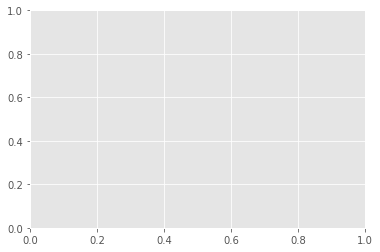

In [30]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./output/loss.png')